<a href="https://colab.research.google.com/github/maqsood28933/jupyter-guide-to-linear-algebra/blob/main/UTS_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [2]:
df = pd.read_csv("Alloys[1].csv")

print(df.shape)
print(df.head())
print(df.info())


(2672, 33)
                                               Alloy  \
0   ACI-ASTM CA15 (SCS1,J91150) Cast Stainless Steel   
1       ACI-ASTM CA15M (J91151) Cast Stainless Steel   
2     ACI-ASTM CA28MWV (J91422) Cast Stainless Steel   
3  ACI-ASTM CA40 (SCS2A,J91153) Cast Stainless Steel   
4       ACI-ASTM CA40F (J91154) Cast Stainless Steel   

   Tensile Strength: Ultimate (UTS) (psi)  Melting Completion (Liquidus)   Al  \
0                                   700.0                         1440.0  0.0   
1                                   690.0                         1450.0  0.0   
2                                  1080.0                         1470.0  0.0   
3                                   910.0                         1440.0  0.0   
4                                   770.0                         1430.0  0.0   

    As    B      C   Ca   Ce   Co  ...      S   Se     Si   Sn   Ta   Ti  \
0  0.0  0.0  0.075  0.0  0.0  0.0  ...  0.020  0.0  0.750  0.0  0.0  0.0   
1  0.0  0.0  

In [3]:
# Drop alloy name / identifiers
df = df.drop(columns=["Alloy"], errors="ignore")


In [4]:
target_column = "Tensile Strength: Ultimate (UTS) (psi)"

X = df.drop(columns=[target_column])
y = df[target_column]


In [5]:
missing_ratio = X.isnull().mean()

features_to_keep = missing_ratio[missing_ratio <= 0.30].index
X = X[features_to_keep]

print(f"Remaining features after 30% rule: {X.shape[1]}")


Remaining features after 30% rule: 31


In [26]:
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


In [28]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


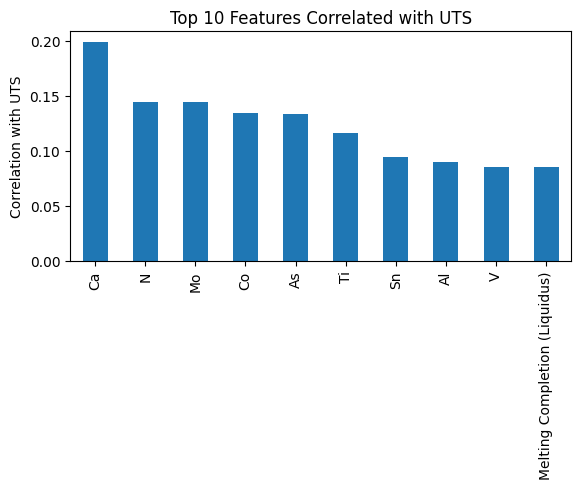

In [8]:
plt.figure(figsize=(6,5))
uts_corr.drop(target_column).head(10).plot(kind="bar")
plt.ylabel("Correlation with UTS")
plt.title("Top 10 Features Correlated with UTS")
plt.tight_layout()
plt.show()


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42
)


In [12]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(kernel="rbf")
}

trained_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model


In [13]:
results = []

for name, model in trained_models.items():
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results.append([name, r2, rmse, mae])

results_df = pd.DataFrame(results, columns=["Model", "R2", "RMSE", "MAE"])
print(results_df.sort_values(by="R2", ascending=False))


               Model        R2        RMSE         MAE
2      Random Forest  0.722700  118.293623   62.096843
3  Gradient Boosting  0.630424  136.564628   82.126786
1   Ridge Regression  0.089011  214.408973  114.184241
0  Linear Regression  0.074912  216.061723  116.399462
4                SVR  0.013056  223.168436  117.622989


In [14]:
best_model = trained_models["Random Forest"]

importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": X_imputed.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feature_importance_df.head(10))


   Feature  Importance
10      Fe    0.174497
4        C    0.126559
19       P    0.088696
23      Si    0.078106
27       V    0.076203
17      Ni    0.073314
13      Mn    0.066684
21       S    0.052415
8       Cr    0.048518
5       Ca    0.045771


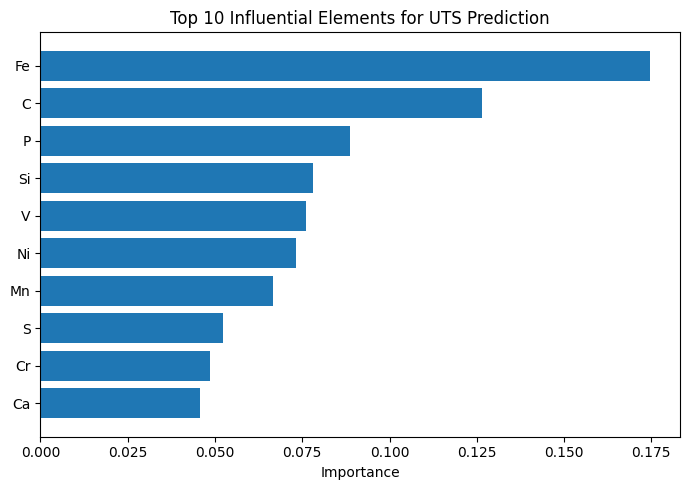

In [15]:
plt.figure(figsize=(7,5))
plt.barh(feature_importance_df["Feature"][:10],
         feature_importance_df["Importance"][:10])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 10 Influential Elements for UTS Prediction")
plt.tight_layout()
plt.show()


In [16]:
from sklearn.model_selection import KFold, cross_validate

cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []

for name, model in models.items():
    scores = cross_validate(
        model, X_scaled, y,
        cv=cv,
        scoring=("r2", "neg_root_mean_squared_error", "neg_mean_absolute_error")
    )

    cv_results.append([
        name,
        scores["test_r2"].mean(),
        -scores["test_neg_root_mean_squared_error"].mean(),
        -scores["test_neg_mean_absolute_error"].mean()
    ])

cv_df = pd.DataFrame(
    cv_results, columns=["Model", "CV R2", "CV RMSE", "CV MAE"]
)

print(cv_df.sort_values(by="CV R2", ascending=False))


               Model     CV R2     CV RMSE      CV MAE
2      Random Forest  0.717910  116.630288   61.336971
3  Gradient Boosting  0.650820  130.118855   79.842403
1   Ridge Regression  0.131572  205.560018  113.708614
0  Linear Regression  0.129339  205.701604  114.668331
4                SVR  0.030221  217.320638  119.873718


In [17]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
}

rf = RandomForestRegressor(random_state=42)

grid = GridSearchCV(
    rf, param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print("Best parameters:", grid.best_params_)


Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


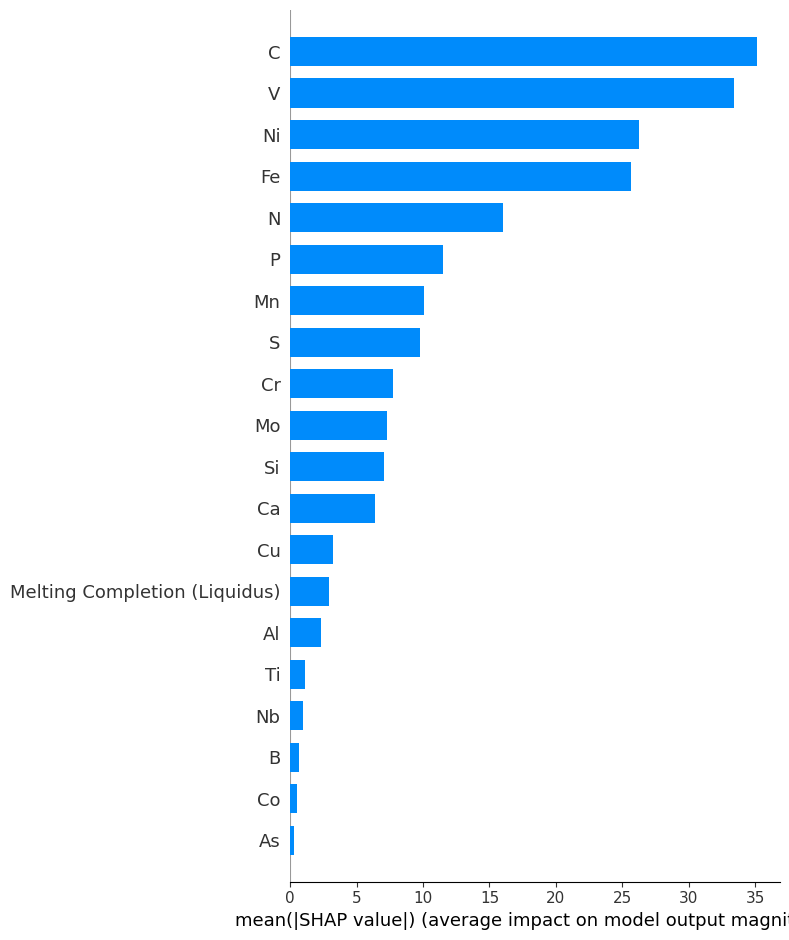

In [18]:
import shap

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(
    shap_values,
    X_train,
    feature_names=X_imputed.columns,
    plot_type="bar"
)


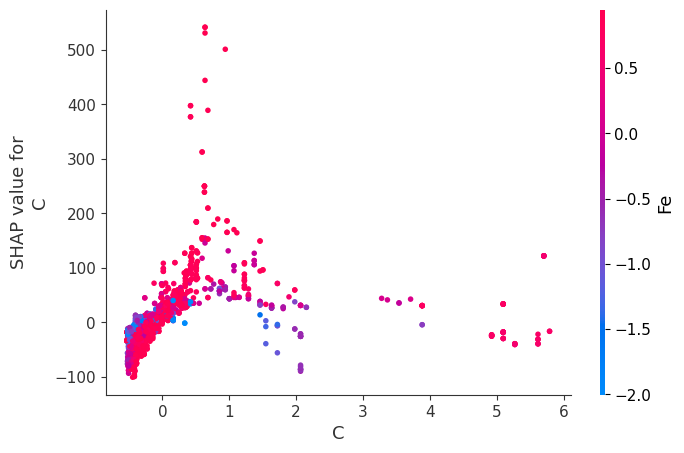

In [19]:
shap.dependence_plot(
    "C", shap_values, X_train,
    feature_names=X_imputed.columns
)


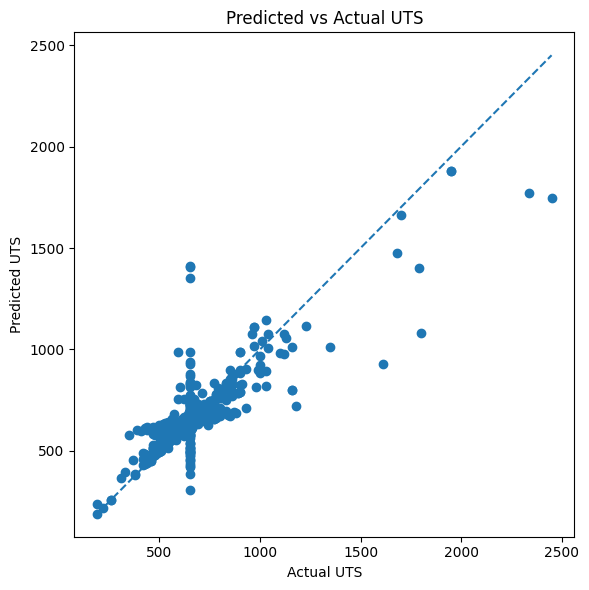

In [20]:
y_pred = best_rf.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], linestyle="--")
plt.xlabel("Actual UTS")
plt.ylabel("Predicted UTS")
plt.title("Predicted vs Actual UTS")
plt.tight_layout()
plt.show()


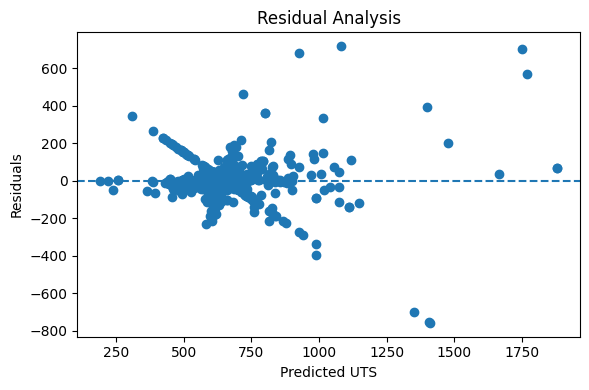

In [21]:
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted UTS")
plt.ylabel("Residuals")
plt.title("Residual Analysis")
plt.tight_layout()
plt.show()


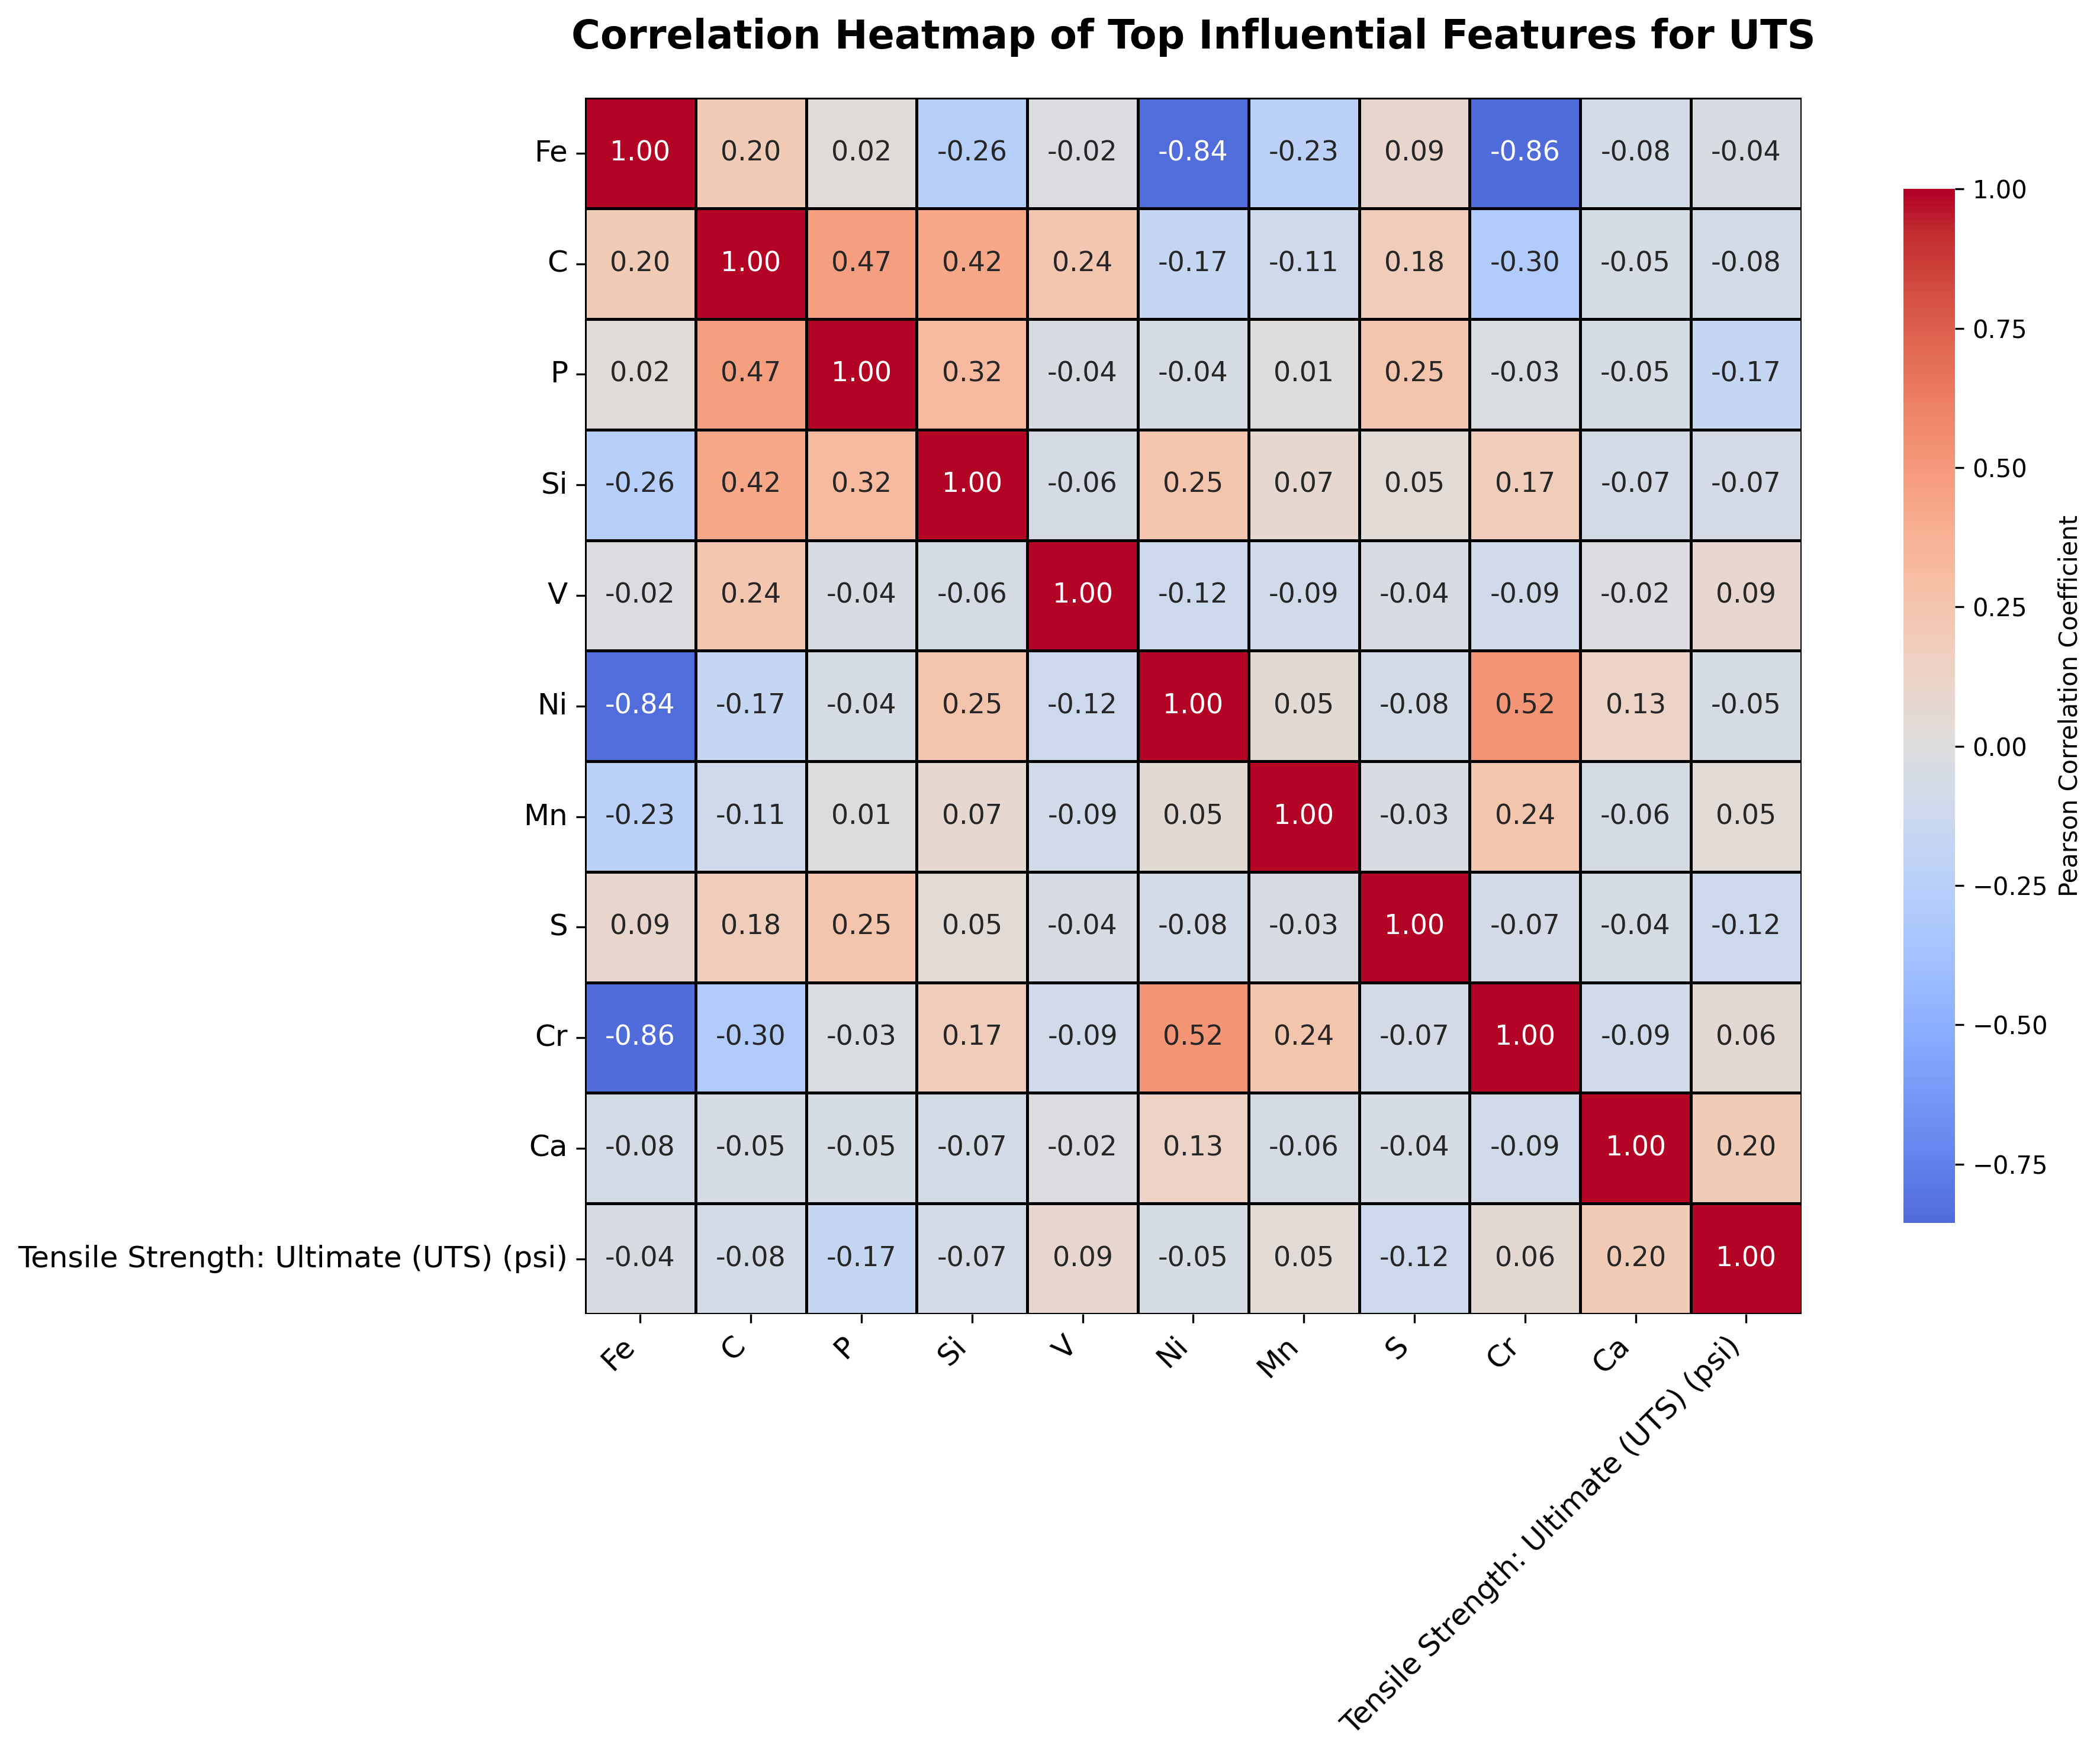

In [23]:
# Select top features
top_features = feature_importance_df["Feature"].iloc[:10]

# Correlation matrix
corr_data = pd.concat(
    [X_imputed[top_features], y], axis=1
).corr()

# Plot
plt.figure(figsize=(14, 10), dpi=300)

ax = sns.heatmap(
    corr_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.8,
    linecolor="black",
    square=True,
    cbar_kws={
        "shrink": 0.85,
        "label": "Pearson Correlation Coefficient"
    },
    annot_kws={"size": 11}
)

# Improve tick labels
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    ha="right",
    fontsize=12
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    fontsize=12
)

# Titles and layout
plt.title(
    "Correlation Heatmap of Top Influential Features for UTS",
    fontsize=16,
    pad=20,
    weight="bold"
)

plt.tight_layout()
plt.show()


In [24]:
plt.savefig("UTS_correlation_heatmap.svg", bbox_inches="tight")
plt.savefig("UTS_correlation_heatmap.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

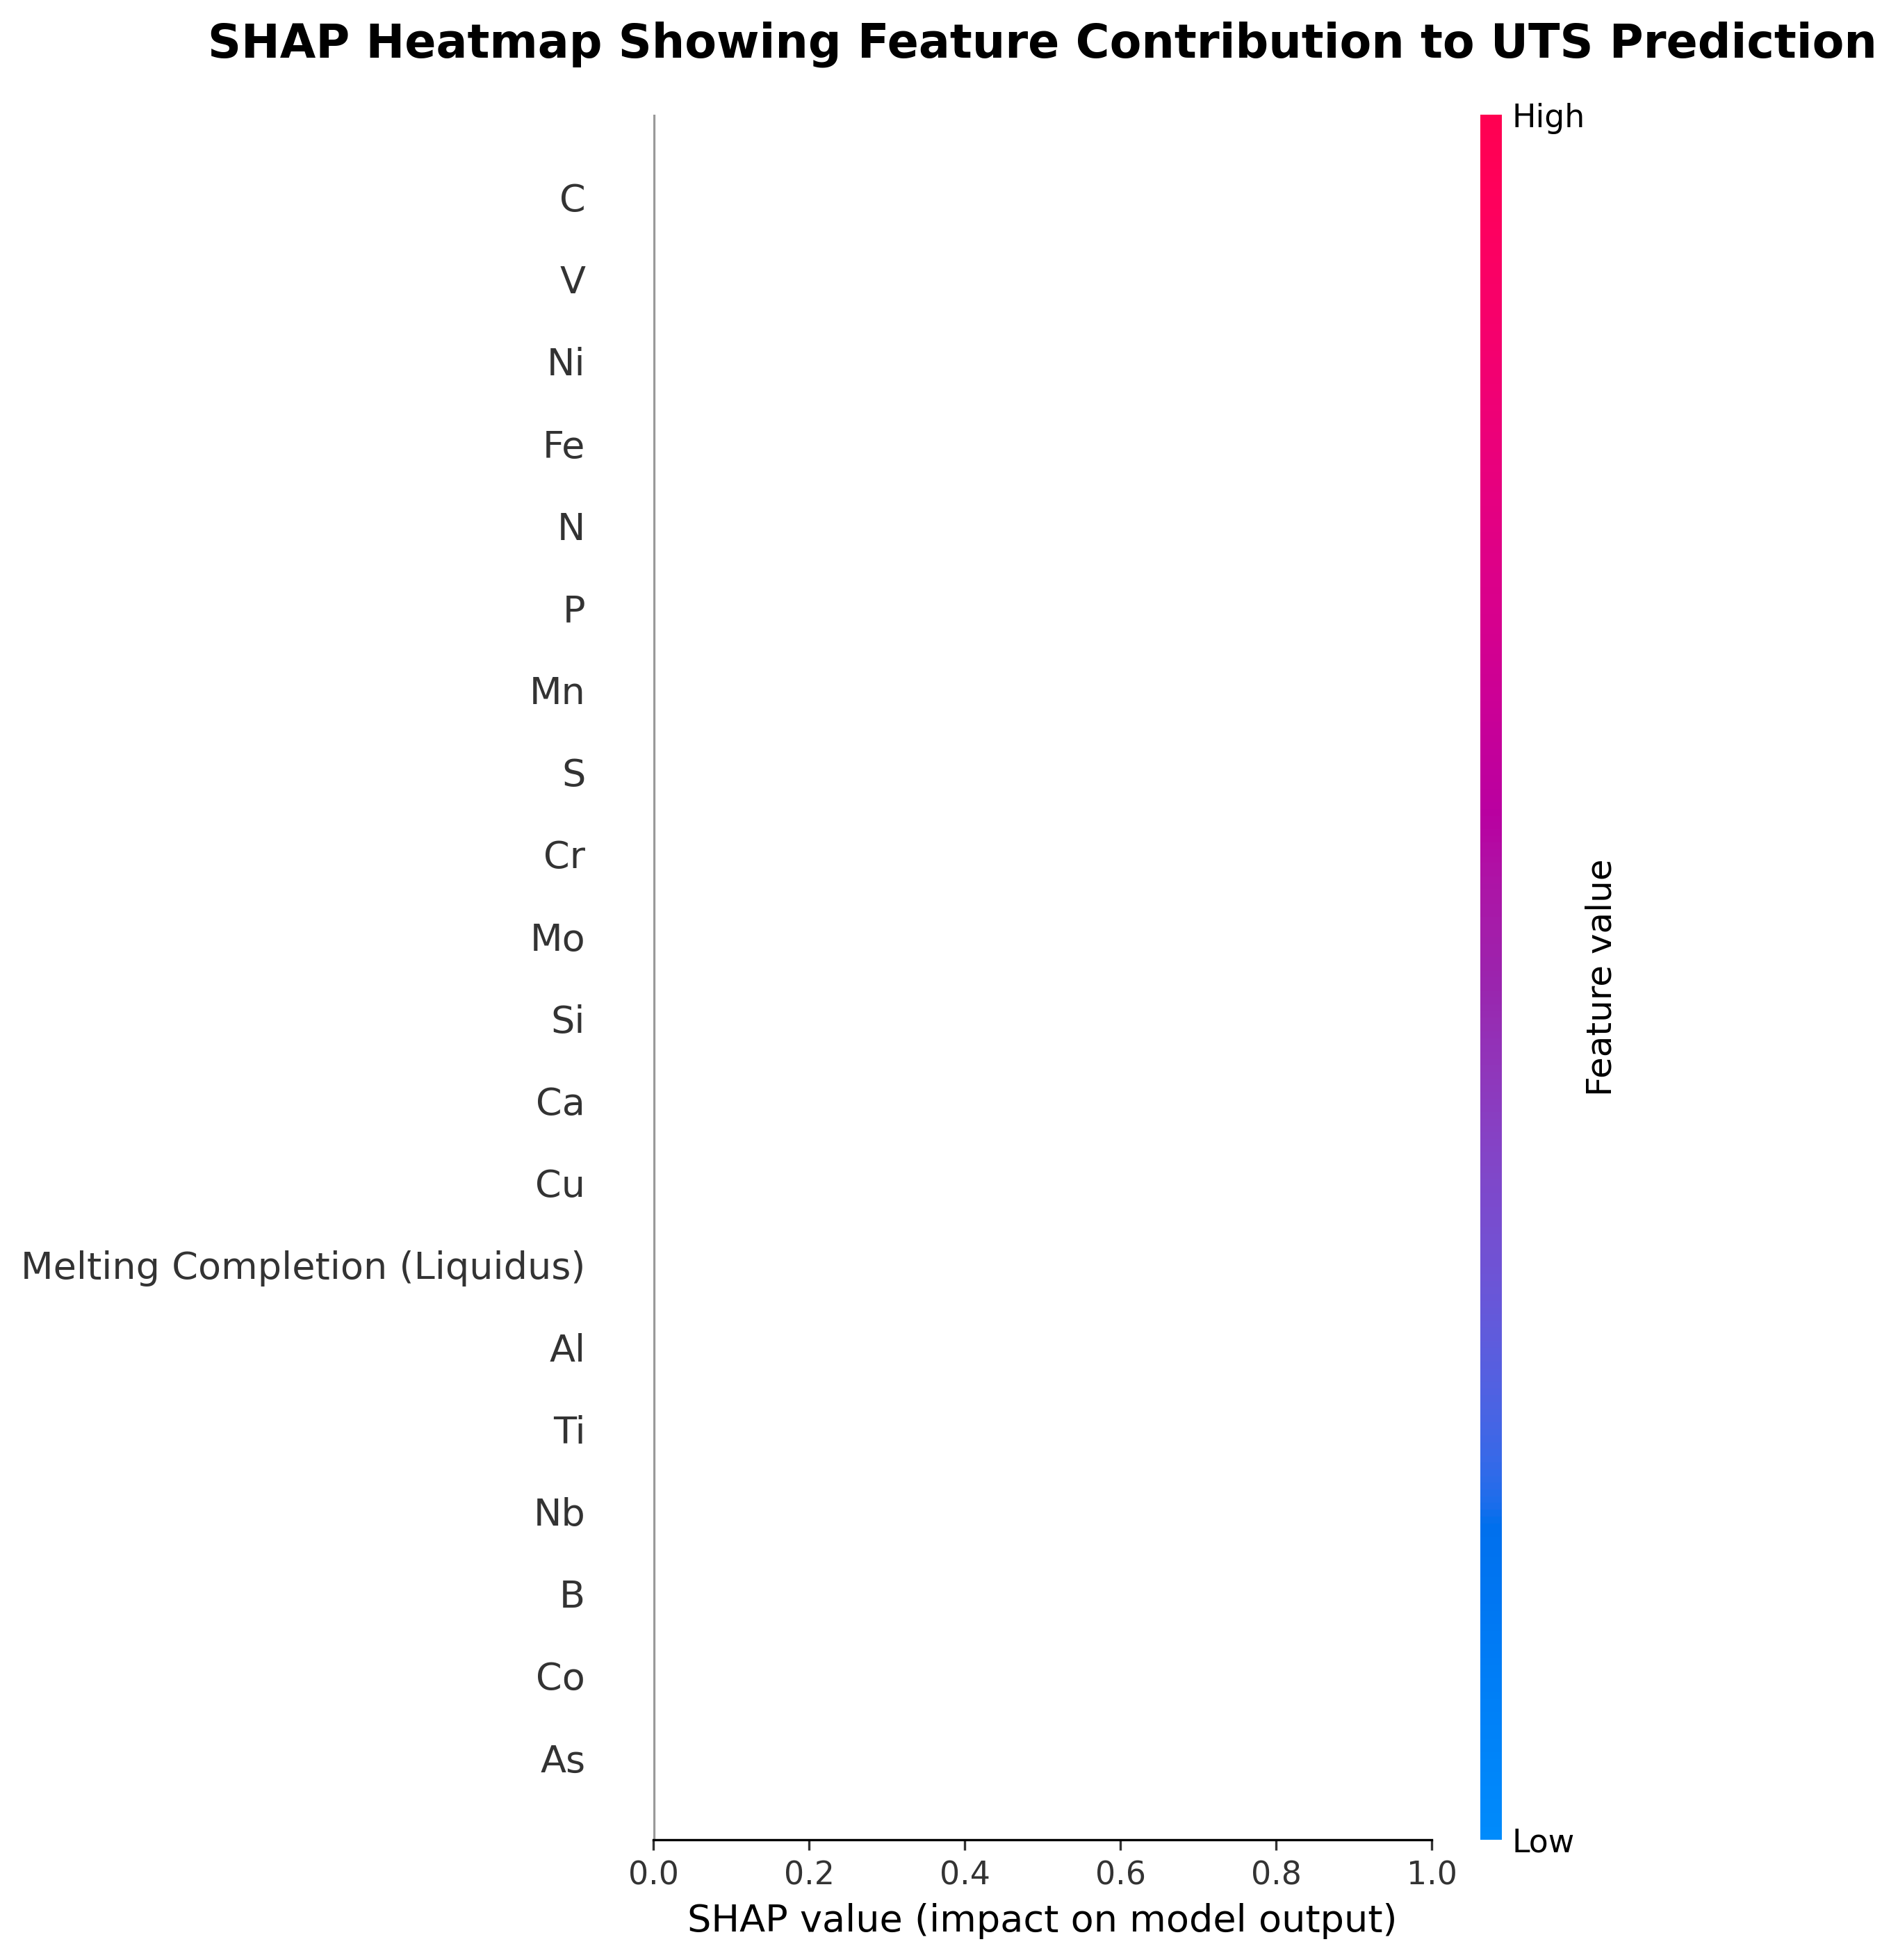

In [25]:
import shap

# Use best model (Random Forest)
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train)

# SHAP heatmap
plt.figure(figsize=(14, 8), dpi=300)
shap.summary_plot(
    shap_values,
    X_train,
    feature_names=X_imputed.columns,
    plot_type="heatmap",
    show=False
)

plt.title(
    "SHAP Heatmap Showing Feature Contribution to UTS Prediction",
    fontsize=16,
    pad=20,
    weight="bold"
)

plt.tight_layout()
plt.show()


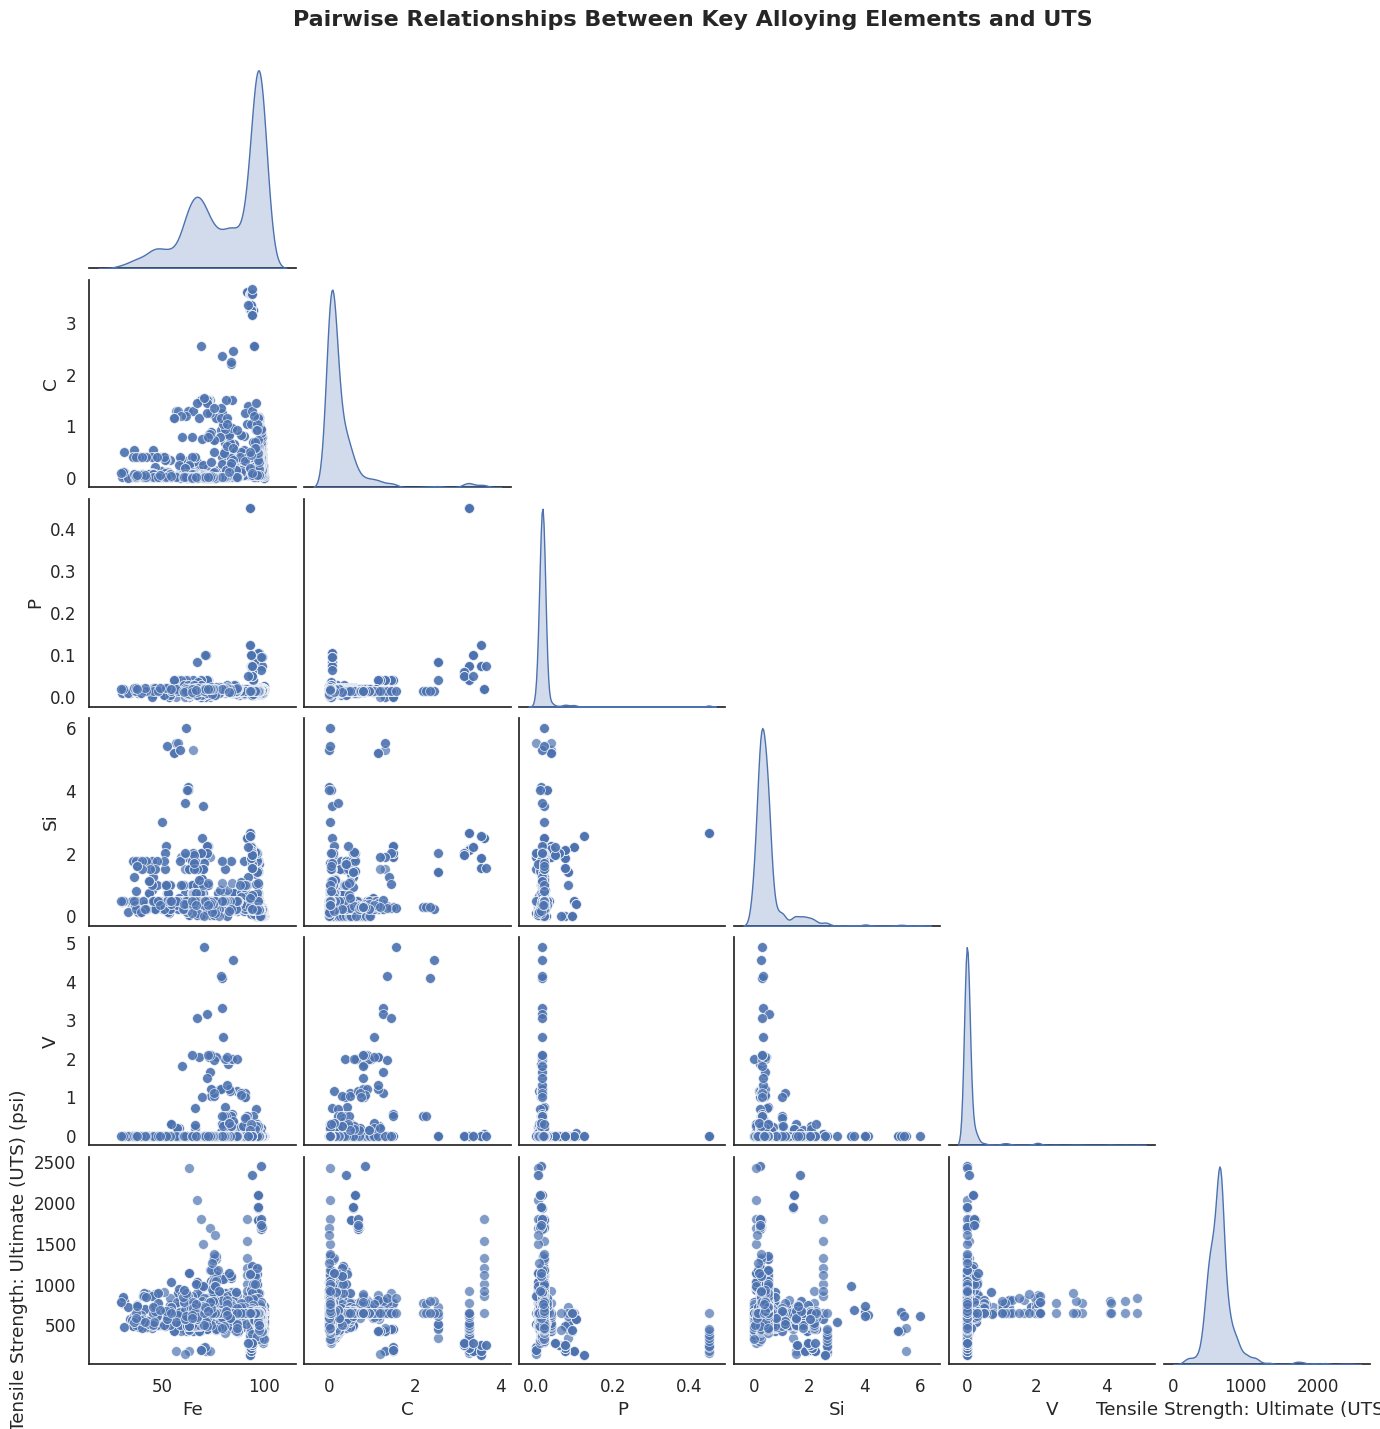

In [30]:
top_features = feature_importance_df["Feature"].iloc[:5]

pairplot_data = pd.concat(
    [X_imputed[top_features], y], axis=1
)

sns.set(style="white", font_scale=1.1)

g = sns.pairplot(
    pairplot_data,
    diag_kind="kde",
    plot_kws={"alpha": 0.7, "s": 50},
    corner=True
)

g.fig.set_size_inches(14, 14)
g.fig.suptitle(
    "Pairwise Relationships Between Key Alloying Elements and UTS",
    fontsize=16,
    y=1.02,
    weight="bold"
)

plt.show()


In [ ]:
def sensitivity_curve(feature_name, model, X_reference, scaler):
    feature_index = list(X_imputed.columns).index(feature_name)

    feature_range = np.linspace(
        X_imputed[feature_name].min(),
        X_imputed[feature_name].max(),
        50
    )

    X_temp = np.tile(X_reference, (50, 1))
    X_temp[:, feature_index] = feature_range

    X_temp_scaled = scaler.transform(X_temp)
    y_pred = model.predict(X_temp_scaled)

    return feature_range, y_pred


# Reference composition = mean alloy
X_ref = X_imputed.mean().values

feature_to_plot = top_features.iloc[0]  # e.g., Carbon

x_vals, y_vals = sensitivity_curve(
    feature_to_plot,
    best_rf,
    X_ref,
    scaler
)

plt.figure(figsize=(7,5), dpi=300)
plt.plot(x_vals, y_vals, linewidth=2)
plt.xlabel(f"{feature_to_plot} Composition")
plt.ylabel("Predicted UTS")
plt.title(
    f"Sensitivity of UTS to {feature_to_plot} Content",
    fontsize=14,
    weight="bold"
)
plt.tight_layout()
plt.show()


In [42]:
print(list(X_imputed.columns))


['Melting Completion (Liquidus)', 'Al', 'As', 'B', 'C', 'Ca', 'Ce', 'Co', 'Cr', 'Cu', 'Fe', 'La', 'Mg', 'Mn', 'Mo', 'N', 'Nb', 'Ni', 'O', 'P', 'Pb', 'S', 'Se', 'Si', 'Sn', 'Ta', 'Ti', 'V', 'W', 'Zn', 'Zr']


Predicted UTS = 870.31


/tmp/ipython-input-2379508870.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.45' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_new.loc[0, k] = v
/tmp/ipython-input-2379508870.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_new.loc[0, k] = v
/tmp/ipython-input-2379508870.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_new.loc[0, k] = v
/tmp/ipython-input-2379508870.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas.

In [46]:
user_input = {
    "C": 0.25,
    "Cr": 1.80,
    "Ni": 1.50,
    "Mn": 0.75,
    "Si": 0.30,
    "Mo": 0.25,
    "V": 0.10
}


In [47]:
import pandas as pd
import numpy as np

cols = X_imputed.columns
X_new = pd.DataFrame(0, index=[0], columns=cols)

for k, v in user_input.items():
    if k in cols:
        X_new.loc[0, k] = v

UTS = best_rf.predict(scaler.transform(X_new))[0]
print(f"Predicted UTS = {UTS:.2f}")


Predicted UTS = 1019.25


/tmp/ipython-input-482689435.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_new.loc[0, k] = v
/tmp/ipython-input-482689435.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_new.loc[0, k] = v
/tmp/ipython-input-482689435.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_new.loc[0, k] = v
/tmp/ipython-input-482689435.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0

In [51]:
elements = ["C", "Cr", "Ni", "Mn", "Si"]   # put 5–6 elements here


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


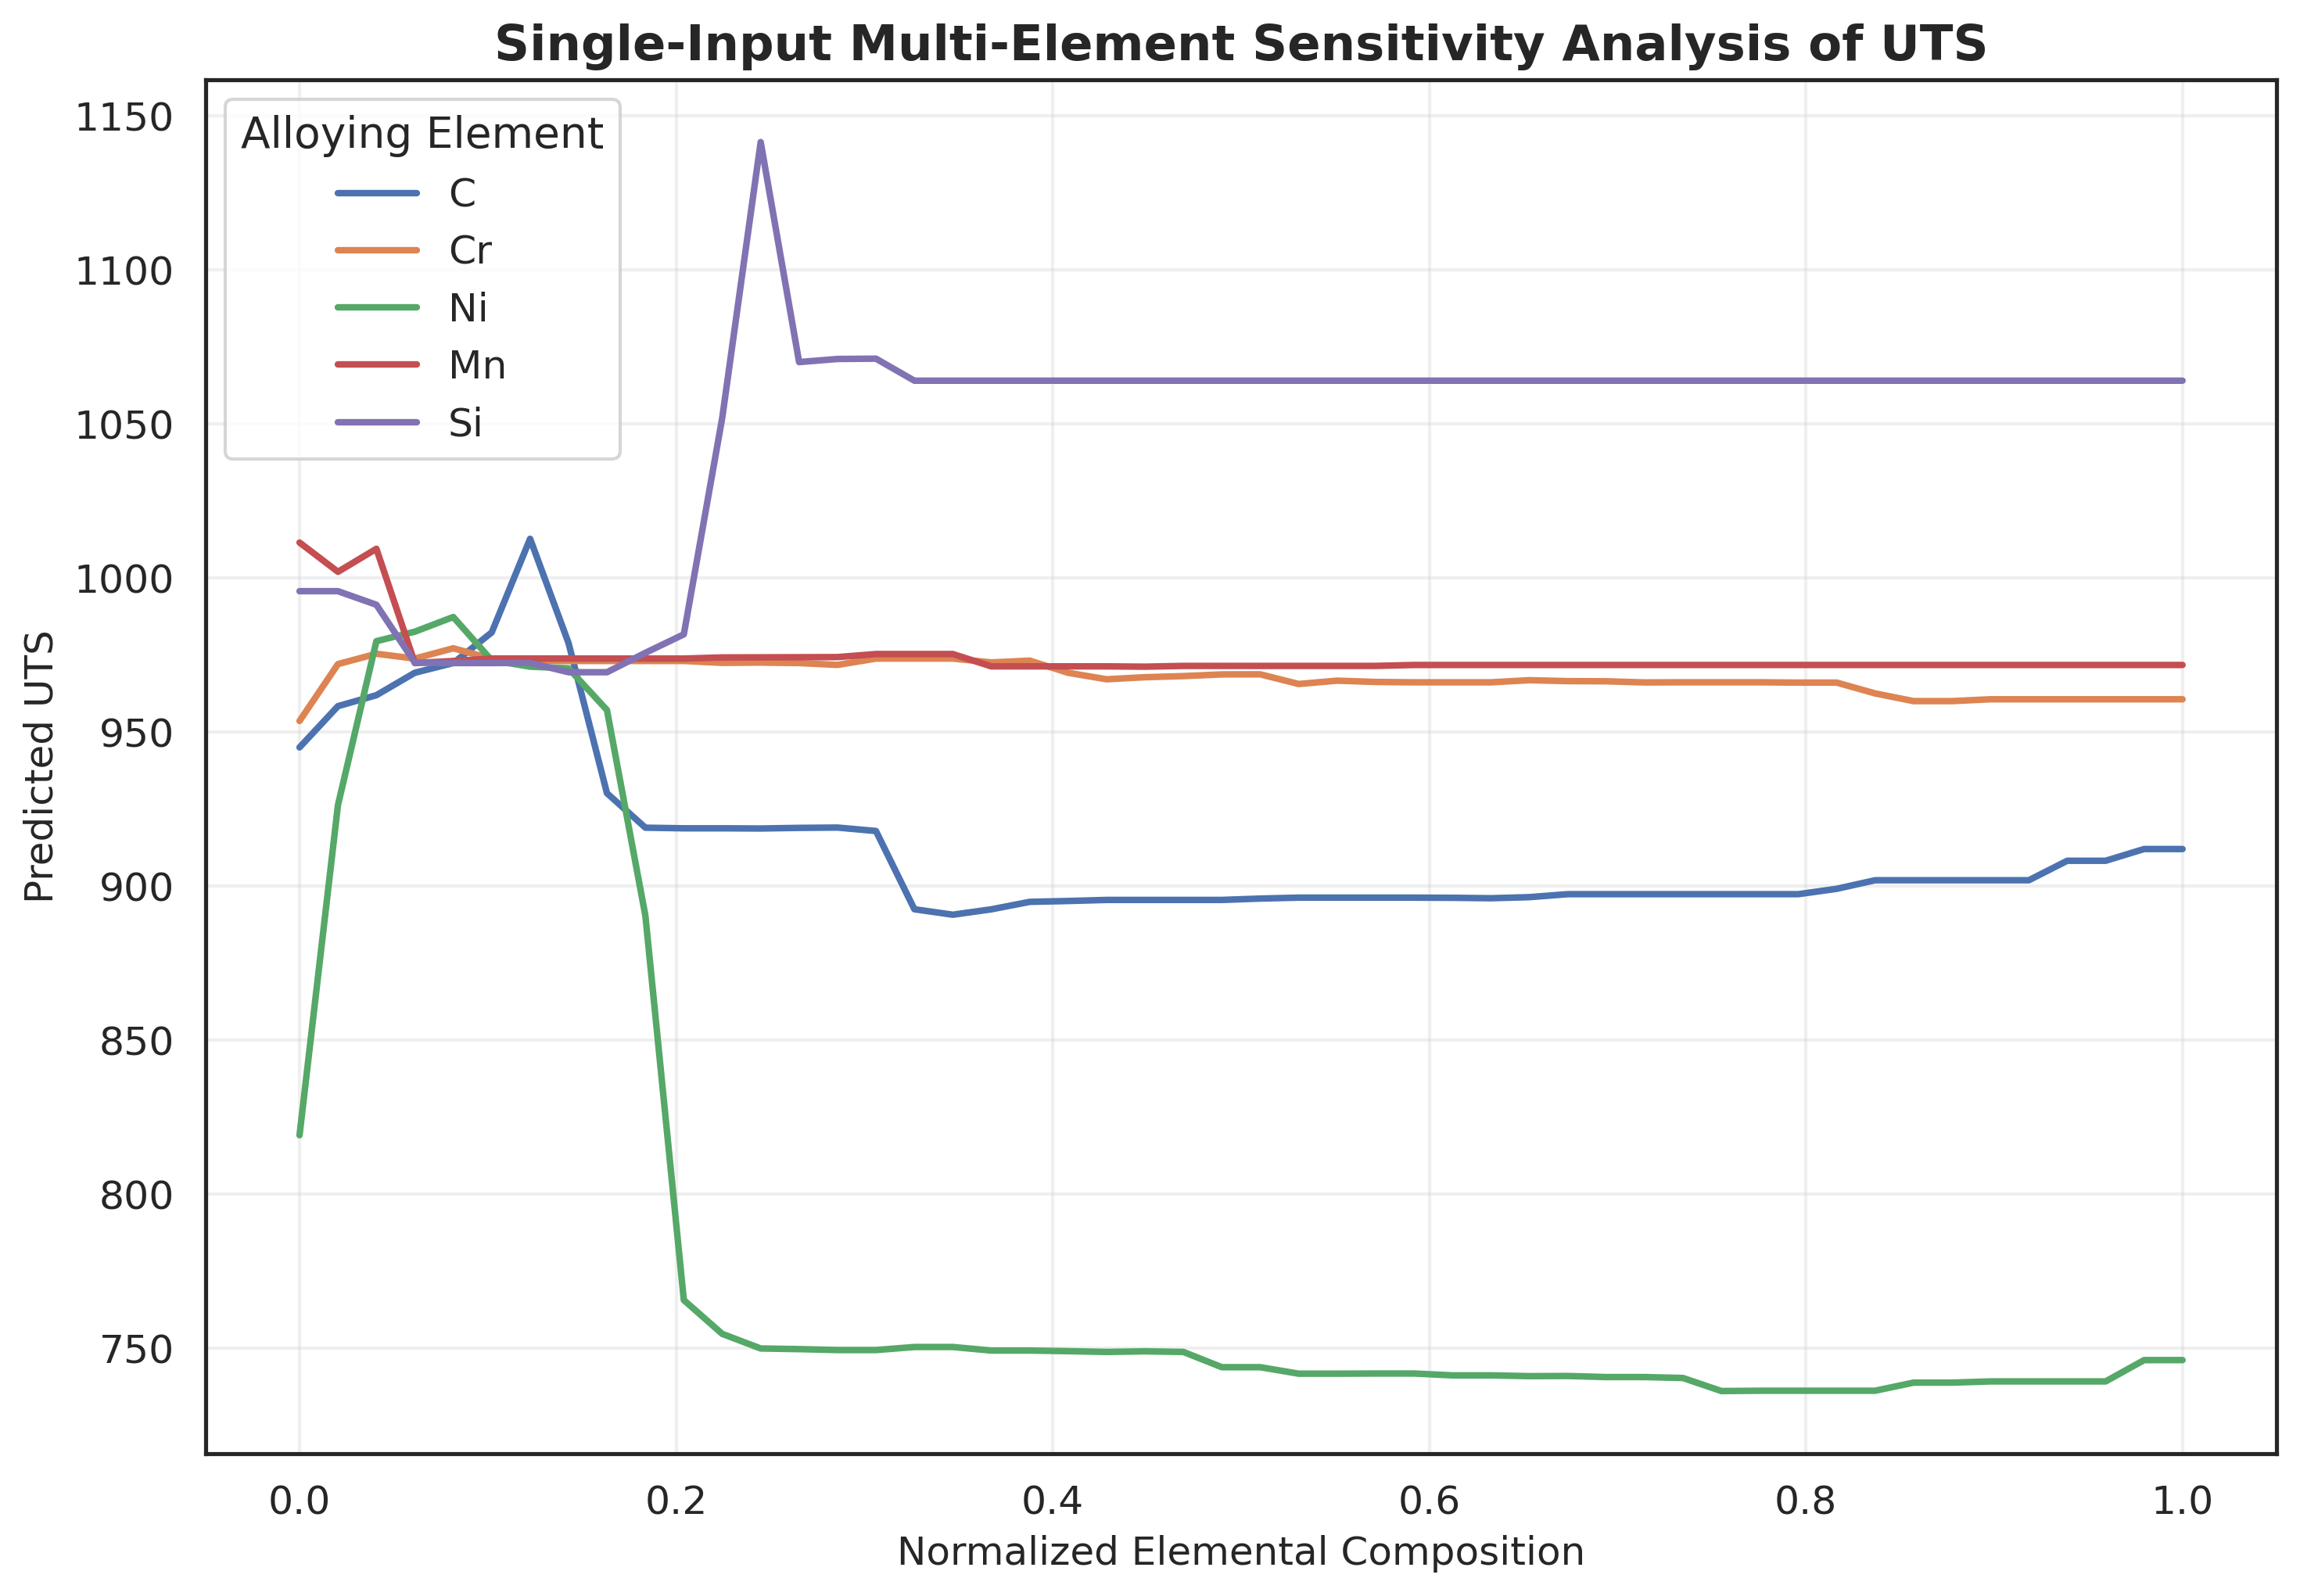

In [52]:
def sensitivity_curve(feature_name, model, X_reference, scaler, n_points=50):
    idx = list(X_imputed.columns).index(feature_name)

    feature_range = np.linspace(
        X_imputed[feature_name].min(),
        X_imputed[feature_name].max(),
        n_points
    )

    X_temp = np.tile(X_reference, (n_points, 1))
    X_temp[:, idx] = feature_range

    y_pred = model.predict(scaler.transform(X_temp))
    return feature_range, y_pred


# Reference alloy = mean composition
X_ref = X_imputed.mean().values

plt.figure(figsize=(10, 7), dpi=300)

for element in elements:
    x, y = sensitivity_curve(element, best_rf, X_ref, scaler)

    # normalize x-axis
    x_norm = (x - x.min()) / (x.max() - x.min())

    plt.plot(x_norm, y, linewidth=2, label=element)

plt.xlabel("Normalized Elemental Composition", fontsize=12)
plt.ylabel("Predicted UTS", fontsize=12)
plt.title(
    "Single-Input Multi-Element Sensitivity Analysis of UTS",
    fontsize=15,
    weight="bold"
)
plt.legend(title="Alloying Element")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
